In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from ultralytics import YOLO
from ultralytics.utils import metrics
from PIL import Image
from pathlib import Path

In [59]:
labels_dict = {
    1: 'Gate Valve, N.C',
    2: 'Ball Valve', 
    3: 'Globe Valve, N.O.', 
    4: 'Gate Valve, N.O.', 
    5: 'Ball Valve', 
    6: 'Butterfly Valve', 
    7: 'Gate Valve, Manually Actuated', 
    8: 'Check Valve', 
    9: 'Diaphragm Valve', 
    10: 'Needle Valve', 
    11: 'Gate Valve, P.C.', 
    12: 'Gate Valve, N.C.', 
    13: 'Globe Valve, N.C',
    14: 'Gate Valve, Pneumatic', 
    15: 'Rotary Valve, N.O.', 
    16: 'Rotary Valve, N.C.', 
    17: 'Open Spacer', 
    18: 'Spectacle Blind, N.C.', 
    19: 'Spectacle Blind, N.O.', 
    20: 'Reducer', 
    21: 'Flange', 
    22: 'Heat Exchanger',
    23: 'Insulation', 
    24: 'Flow Arrow', 
    25: 'Circle Valve',
    26: 'Inline Indicator', 
    27: 'Inline Flow Meter',
    27: 'Shared Display, Local',
    28: 'Shared Display, Remote',
    29: 'Control Panel',
    30: 'Non-Inline Flow Meter',
    31: 'Control Measurement Point',
    32: 'Gauge',
    33: 'PLC',
    33: 'Swinging Disk Check Valve',
    34: 'Hose Bib',
    35: 'Pressure Vessel',
    36: 'Centrifugal Pump',
    37: 'Motor',
    38: 'Coupling',
    39: 'Continuation Arrow'
}

In [60]:
def update_histogram(hist, data):
    
    unique, counts = np.unique(data, return_counts=True)

    for key, value in zip(unique, counts):
        hist[key] = hist.get(value, 0) + value
    
    return hist


histogram = {}

for i in range(500):
    symbols = np.load(fr'C:\Users\Andrew Deur\Documents\NYU\DS-GA 1006 Capstone\Data\DigitizePID_Dataset\{i}\{i}_symbols.npy', allow_pickle=True)
    symbols = symbols[:, -1].astype(int)
    histogram = update_histogram(histogram, symbols)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Andrew Deur\\Documents\\NYU\\DS-GA 1006 Capstone\\Data\\DigitizePID_Dataset\\0\\0_symbols.npy'

In [4]:
plot_histogram = {labels_dict[key]: int(value) for key, value in histogram.items()}

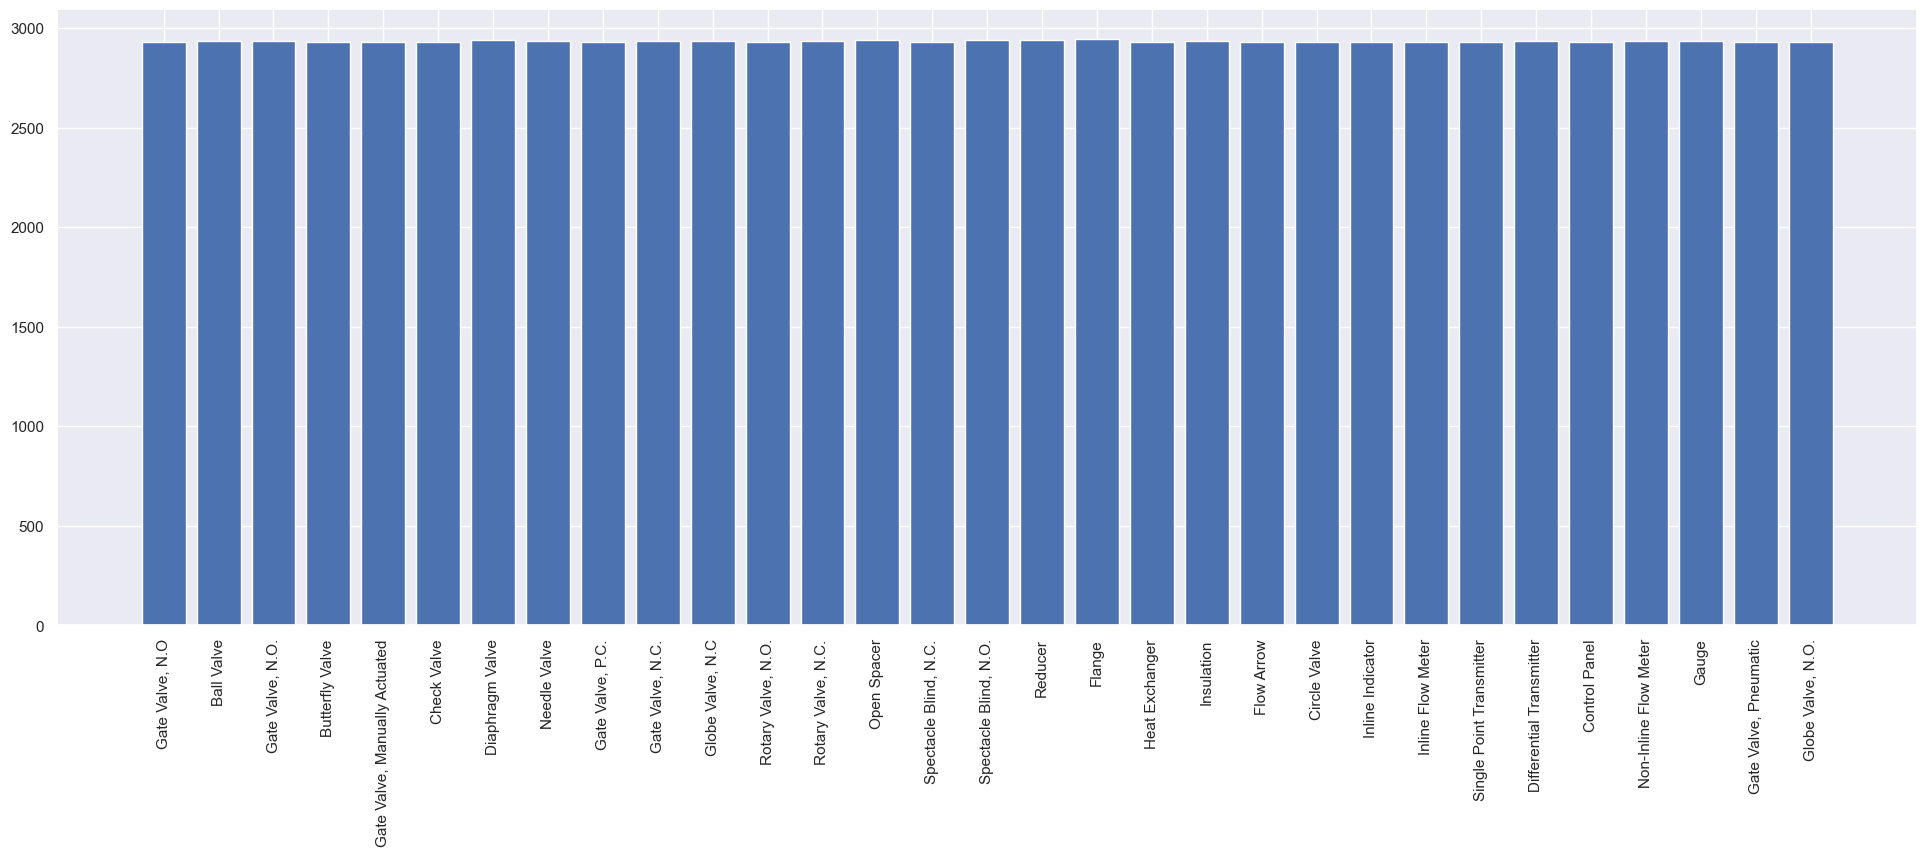

In [40]:
ind = np.arange(0, len(plot_histogram))
plt.figure(figsize=(24, 8)) 

plt.bar(ind, list(plot_histogram.values()))
plt.xticks(ind, list(plot_histogram.keys()))
plt.xticks(rotation=90)
plt.show()

In [24]:
for i in range(500):

    dataset = "train" if i < 400 else "val"
    im = Image.open(f'Data/synthetic_1/images/{dataset}/{i}.jpg')

    # Assigning the desired crop region (x1, y1, x2, y2)
    (left, upper, right, lower) = (400, 400, 5668, 4161) # Crops out borders & title block{}

    im_crop = im.crop((left, upper, right, lower))
    im_crop.save(f"Data/synthetic_1_cropped/images/{dataset}/{i}.jpg")

## Inference

In [442]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bboxes(image, boxes, box_color, title):
    """
    Plots bounding boxes on the image.
    
    Parameters:
    - image: The background image on which to plot the boxes
    - boxes: Bounding boxes in xyxy format
    - box_color: The color for the bounding boxes
    - title: Title of the plot
    """
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=box_color, facecolor='none')
        ax.add_patch(rect)
    
    ax.set_title(title)
    plt.show()

In [443]:
def detection_metrics(iou, iou_threshold=0.7):    
    
    valid_iou_mask = iou >= iou_threshold
    overall_iou = iou[valid_iou_mask].mean() if valid_iou_mask.any() else torch.tensor(0.0)
    
    # Determine true positives, false positives, and false negatives
    true_positives = (valid_iou_mask.sum(dim=1) > 0).sum().item()  # Number of predictions with at least one valid IoU
    false_positives = (valid_iou_mask.sum(dim=1) == 0).sum().item()  # Predictions without a valid IoU
    false_negatives = (valid_iou_mask.sum(dim=0) == 0).sum().item()  # Ground truths without any valid predictions

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    print(f"Overall IoU: {overall_iou.item():.3f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

In [444]:
def convert_yolo_to_torch(coords, height, width, x1, y1, cropped=None):
        """
        Converts yolo format (class_id   center_x  center_y  width  height) -->
        to torch format (x1, y1, x2, y2). Yolo format is normalized & torch format 
        isn't, so need to scale by image dimensions
        """
        #label, center_x, center_y, bb_width, bb_height = coords

        # Bounding Boxes annotated on uncropped image, adjust to orig dims
        coords[:, 1] *= width 
        coords[:, 2] *= height 
        coords[:, 3] *= width 
        coords[:, 4] *= height 

        if cropped:
                coords[:, 1] -= x1
                coords[:, 2] -= y1 

        x_min = coords[:, 1] - (0.5 * coords[:, 3])
        y_min = coords[:, 2] - (0.5 * coords[:, 4])

        x_max = coords[:, 1] + (0.5 * coords[:, 3])
        y_max = coords[:, 2] + (0.5 * coords[:, 4])
        
        return torch.stack((x_min, y_min, x_max, y_max), dim=1)

In [445]:
def inference(run, root, conf_thresh=0.5, iou_thresh=0.5, cropped=None):
    model = YOLO(f'runs/detect/train{run}/weights/best.pt')
    test_path = root / 'Data' / 'test' / f'fw_system-1{"_cropped" if cropped else ""}.jpg'

    preds = model.predict(
        test_path, 
        save=True, 
        show_labels=False, 
        imgsz=3200, 
        agnostic_nms=True,
        conf=conf_thresh,
        iou=iou_thresh
    )
    return preds

In [460]:
root = Path().resolve().parents[1]

im_path = root / 'Data' / 'test' / 'fw_system-1.jpg'
im = Image.open(im_path)

IMAGE_WIDTH = 2339
IMAGE_HEIGHT = 1653
X1 = 100
X2 = 1779
Y1 = 200
Y2 = 1403

# Assigning the desired crop region (x1, y1, x2, y2)
(left, upper, right, lower) = (100, 200, 1779, 1403) # Crops out borders & title block{}

im_crop = im.crop((left, upper, right, lower))

save_path = root / 'Data' / 'test' / 'fw_system-1_cropped.jpg'
im_crop.save(save_path)

test_labels = root / 'Data' / 'test' / 'labels' / 'cf884cd3-fw_system-1.txt'
with open(test_labels, 'r') as f:
    lines = f.readlines()

# Convert text to numpy array
label_data = np.array([list(map(float, line.split())) for line in lines])
# Create a PyTorch tensor from the numpy array
label_tensor = torch.from_numpy(label_data)

In [450]:
label_tensor_torch = convert_yolo_to_torch(label_tensor, IMAGE_HEIGHT, IMAGE_WIDTH, X1, Y1, cropped=True)
results = inference(2, root, cropped=True)
pred_bboxes = results[0].boxes.xyxy.clone()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
iou = metrics.box_iou(label_tensor_torch.to(device), pred_bboxes, eps=1e-07)


image 1/1 C:\Users\Andrew Deur\Documents\NYU\DS-GA 1006 Capstone\Data\test\fw_system-1_cropped.jpg: 2304x3200 4 Flanges, 6 Single Point Transmitters, 26.1ms
Speed: 42.1ms preprocess, 26.1ms inference, 2.0ms postprocess per image at shape (1, 3, 2304, 3200)
Results saved to runs\detect\predict4


## 32 Granular Classes

In [451]:
detection_metrics(iou, iou_threshold=0.7)

Overall IoU: 0.808
Precision: 0.0187
Recall: 0.2000


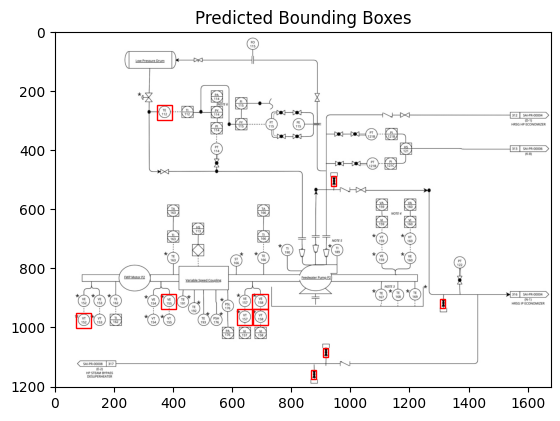

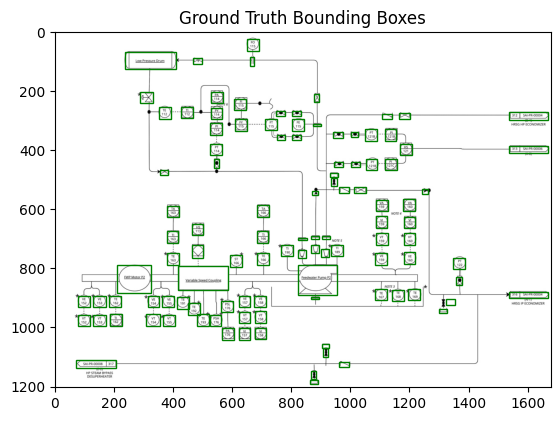

In [452]:
# Convert the PIL image to a numpy array for visualization
im_np = np.array(im_crop)
# Plot predicted bounding boxes (red)
plot_bboxes(im_np, pred_bboxes.cpu(), box_color='r', title='Predicted Bounding Boxes')
# Plot ground truth bounding boxes (green)
plot_bboxes(im_np, label_tensor_torch.cpu(), box_color='g', title='Ground Truth Bounding Boxes')

## 6 Generic Clcasses

### Hyper Parameters

hsv_h: 0 \
hsv_s: 0 \
hsv_v: 0.5 \
degrees: 10 \
translate: 0.1 \
scale: 0.25 \
shear: 0.0 \
perspective: 0.0 \
flipud: 0.0 \
fliplr: 0 \
bgr: 0.0 \
mosaic: 1.0 \
mixup: 0.0 \
copy_paste: 0.5 \
copy_paste_mode: flip \
auto_augment: randaugment \
erasing: 0.3 \
crop_fraction: 0.2 

In [461]:
label_tensor_torch = convert_yolo_to_torch(label_tensor, IMAGE_HEIGHT, IMAGE_WIDTH, X1, Y1, cropped=True)
results = inference(5, root, cropped=True)
pred_bboxes = results[0].boxes.xyxy.clone()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
iou = metrics.box_iou(label_tensor_torch.to(device), pred_bboxes, eps=1e-07)


image 1/1 C:\Users\Andrew Deur\Documents\NYU\DS-GA 1006 Capstone\Data\test\fw_system-1_cropped.jpg: 2304x3200 8 Valves, 11 Mechanical Connections, 6 Flow Arrows, 60 Control Symbols, 27.5ms
Speed: 31.8ms preprocess, 27.5ms inference, 1.0ms postprocess per image at shape (1, 3, 2304, 3200)
Results saved to runs\detect\predict8


In [462]:
detection_metrics(iou, iou_threshold=0.7)

Overall IoU: 0.737
Precision: 0.5047
Recall: 0.6353


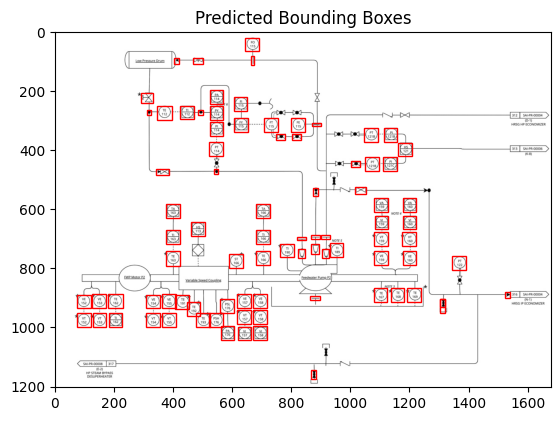

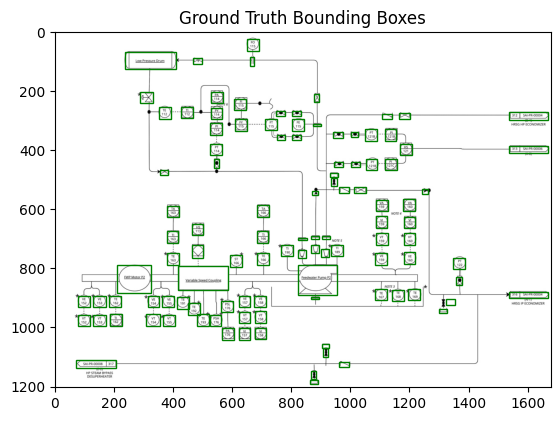

In [463]:
# Convert the PIL image to a numpy array for visualization
im_np = np.array(im_crop)
# Plot predicted bounding boxes (red)
plot_bboxes(im_np, pred_bboxes.cpu(), box_color='r', title='Predicted Bounding Boxes')
# Plot ground truth bounding boxes (green)
plot_bboxes(im_np, label_tensor_torch.cpu(), box_color='g', title='Ground Truth Bounding Boxes')

### Hyper Parameters:

hsv_h = 0, # P&IDs will be b/w, don't modify hue \
hsv_s = 0, # or saturation \
hsv_v = 0.5, # Brightness \
scale = .5, # Scale for larger variations in equip size \
degrees = 10, # Rotation \
copy_paste = 0.5, # Copy \
crop_fraction = 0.25, \
erasing = 0.3 

In [459]:
label_tensor_torch = convert_yolo_to_torch(label_tensor, IMAGE_HEIGHT, IMAGE_WIDTH, X1, Y1, cropped=True)
results = inference(6, root, cropped=True)
pred_bboxes = results[0].boxes.xyxy.clone()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
iou = metrics.box_iou(label_tensor_torch.to(device), pred_bboxes, eps=1e-07)


image 1/1 C:\Users\Andrew Deur\Documents\NYU\DS-GA 1006 Capstone\Data\test\fw_system-1_cropped.jpg: 2304x3200 16 Valves, 10 Mechanical Connections, 2 Flow Arrows, 63 Control Symbols, 26.4ms
Speed: 33.1ms preprocess, 26.4ms inference, 1.0ms postprocess per image at shape (1, 3, 2304, 3200)
Results saved to runs\detect\predict7


In [457]:
detection_metrics(iou, iou_threshold=0.5)

Overall IoU: 0.730
Precision: 0.7850
Recall: 0.9231


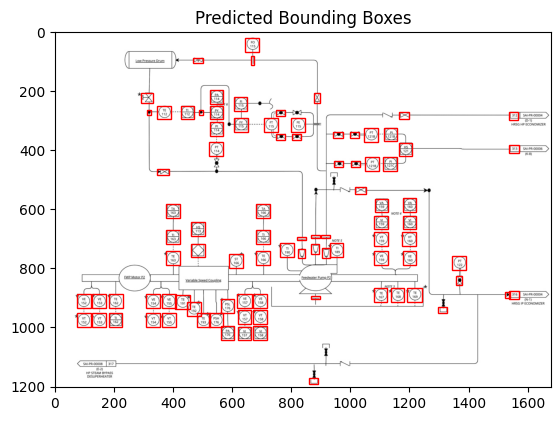

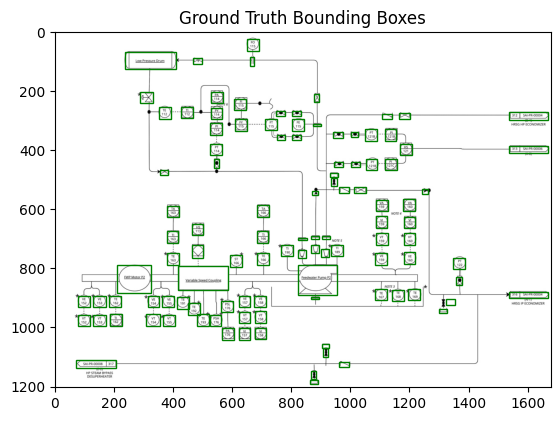

In [458]:
# Convert the PIL image to a numpy array for visualization
im_np = np.array(im_crop)
# Plot predicted bounding boxes (red)
plot_bboxes(im_np, pred_bboxes.cpu(), box_color='r', title='Predicted Bounding Boxes')
# Plot ground truth bounding boxes (green)
plot_bboxes(im_np, label_tensor_torch.cpu(), box_color='g', title='Ground Truth Bounding Boxes')